In [67]:
from dotenv import load_dotenv
# Library that has a lot of operating system functions
from os import getenv
import requests
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re

import pymongo
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bsajjan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load from the .env
load_dotenv()

# Get the Reddit credentials from environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

In [3]:
# Check that the variables all loaded
if APP_NAME and APP_ID and APP_SECRET and USERNAME and PASSWORD:
    print("Credentials loaded")
else:
    print("ERROR: Credentials not loaded!!")

Credentials loaded


In [4]:
# Sets up the authentication part of the request
auth = requests.auth.HTTPBasicAuth(f'{APP_ID}', f'{APP_SECRET}')

# Sets up the data we want to send: our login method (password), username, and password
data = {'grant_type': 'password',
        'username': f'{USERNAME}',
        'password': f'{PASSWORD}'}

# Sets up this requests header info, which gives reddit a brief description of our app
# This is the format requested by Reddit: os:app_name:version (by /u/username)
headers = {'User-Agent': f'macos:{APP_NAME}:v1.0 (by /u/{USERNAME})'}

# Makes the request to the access_token api endpoint, and saves the response in res
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# Converts response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# Adds authorisation to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# While the token is valid (~2 hours) we can just add headers=headers to our requests to prove authentication
# Making a test request. <Response [200]> means that it was a success!
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

### Creating Functions for reusability
After writing the code lines one-by-one and verifying the correctness, organizing the code into functions for better reusuability and correctness.

In [5]:
# Function to search Reddit posts
def search_reddit(subreddit, keyword):
    # Searching for a keyword within sub-reddit for last 1 year and sort by comments
    # https://www.reddit.com/dev/api#GET_search
    params = {'limit': 100, 'restrict_sr': 1, 'sr_nsfw': 1, 't': 'all', 'sort': 'comments'}
    search_results = []

    for i in range(100):
        res = requests.get(
            f"https://oauth.reddit.com/r/{subreddit}/search?q={keyword}",
            headers=headers,
            params=params
        )

        results = res.json()['data']['children']
        search_results.extend(results)

        # Get the ID of last post and start next search after it
        try:
            fullname = f"{results[-1]['kind']}_{results[-1]['data']['id']}"
            # This tells the API that the post we want is the one after the current one in the queue (ie is the next oldest one).
            params['after'] = fullname
            # Sleeping for 1 second to not exceed Reddit's API limits
            time.sleep(1)
        except:
            print(f"No search results after last result ID: {params['after']}")
            break

    # Total search results for the keyword
    print(f"Search results: {len(search_results)}")
    return get_comments_for_posts(search_results)


# Function to get comments/replies for each post
def get_comments_for_posts(search_results):
    # Define a list to store all the post and comment responses
    comments = []
    for post in search_results:
        # Get comments for each post
        res = requests.get(
            f"https://oauth.reddit.com{post['data']['permalink']}",
            headers=headers
        )
        # Add the retreived post body
        post = res.json()[0]['data']['children'][0]['data']
        replies = res.json()[1]['data']['children']
        comments.append({'created_utc': post['created_utc'],
                      'author': post['author'],
                      'post_id': post['id'],
                      'subreddit': post['subreddit'],
                     'text': post['selftext']})
        # Add the retreived comments to "comments" list
        # Loop through the comments and extract the reply bodies
        for comment in replies:
            reply_bodies = extract_reply_body(comment)
            if reply_bodies:
                comments.append(reply_bodies)
        
        # Sleeping for 0.1 second to not exceed Reddit's API limits
        time.sleep(0.1)

    print(f"Total comments retreived: {len(comments)}")
    return comments
    
# Define a function to extract the reply body from a comment or a reply
# It takes reply as input and returns its body or list of bodies
def extract_reply_body(reply):
    if reply['kind'] == 't1':
        # If the reply is a comment, extract the comment body
        return {
            'created_utc': reply['data']['created'],
            'author': reply['data']['author'],
            'post_id': reply['data']['link_id'].split('_')[1],
            'subreddit': reply['data']['subreddit'],
            'text': reply['data']['body']
        }
    elif reply['kind'] == 'Listing':
        # If the reply is a listing of replies, traverse the listing and extract the reply bodies
        reply_bodies = []
        for child in reply['data']['children']:
            reply_body = extract_reply_body(child)
            if reply_body:
                reply_bodies.append(reply_body)
        return reply_bodies

In [6]:
# Creating DF from search results for "house contruction" in Reddit
irish_construction_posts_df = pd.DataFrame.from_dict(search_reddit("ireland", "house construction"))
irish_construction_posts_df.head()

No search results after last result ID: t3_rtkitj
Search results: 131
Total comments retreived: 1789


,created_utc,author,post_id,subreddit,text
0,1.674811e+09,tashadaily,10mgkxn,ireland,Right so obviously a burner account.\n\nMy fia...
1,1.674818e+09,PedantJuice,10mgkxn,ireland,"First; this is perfectly, perfectly human way ..."
2,1.674814e+09,FullyStacked92,10mgkxn,ireland,The reason your life isn't comfortable on a co...
3,1.674817e+09,theriskguy,10mgkxn,ireland,"You’re directing your anger in the wrong, dire..."
4,1.674812e+09,slice_of_za,10mgkxn,ireland,Sounds like you're having a shitty time of it ...


In [7]:
irish_construction_posts_df['created_utc'] = pd.to_datetime(irish_construction_posts_df['created_utc'], unit='s')
irish_construction_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789 entries, 0 to 1788
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   created_utc  1789 non-null   datetime64[ns]
 1   author       1789 non-null   object        
 2   post_id      1789 non-null   object        
 3   subreddit    1789 non-null   object        
 4   text         1789 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 70.0+ KB


In [8]:
irish_construction_posts_df.head()

,created_utc,author,post_id,subreddit,text
0,2023-01-27 09:09:44,tashadaily,10mgkxn,ireland,Right so obviously a burner account.\n\nMy fia...
1,2023-01-27 11:15:03,PedantJuice,10mgkxn,ireland,"First; this is perfectly, perfectly human way ..."
2,2023-01-27 09:59:22,FullyStacked92,10mgkxn,ireland,The reason your life isn't comfortable on a co...
3,2023-01-27 10:59:06,theriskguy,10mgkxn,ireland,"You’re directing your anger in the wrong, dire..."
4,2023-01-27 09:36:50,slice_of_za,10mgkxn,ireland,Sounds like you're having a shitty time of it ...


In [9]:
# Creating DF from search results for "house contruction" in Reddit
irish_housing_posts_df = pd.DataFrame.from_dict(search_reddit("ireland", "housing"))
irish_housing_posts_df.head()

No search results after last result ID: t3_mla0zq
Search results: 230
Total comments retreived: 14696


,created_utc,author,post_id,subreddit,text
0,1.663774e+09,coluber_,xk7udf,ireland,Hi all. I see the topic of Ukrainian refugees ...
1,1.663774e+09,pul123PUL,xk7udf,ireland,What has been the biggest challenge for you da...
2,1.663780e+09,Fantastic_Section517,xk7udf,ireland,Are you working at present? The reason I ask i...
3,1.663777e+09,EDITORDIE,xk7udf,ireland,I wish you and your family the best and hope t...
4,1.663774e+09,ImpressionPristine46,xk7udf,ireland,Have all your family and friends moved to Irel...


In [10]:
# Converting to datetime
irish_housing_posts_df['created_utc'] = pd.to_datetime(irish_housing_posts_df['created_utc'], unit='s')
irish_housing_posts_df.head()

,created_utc,author,post_id,subreddit,text
0,2022-09-21 15:21:22,coluber_,xk7udf,ireland,Hi all. I see the topic of Ukrainian refugees ...
1,2022-09-21 15:29:39,pul123PUL,xk7udf,ireland,What has been the biggest challenge for you da...
2,2022-09-21 17:06:30,Fantastic_Section517,xk7udf,ireland,Are you working at present? The reason I ask i...
3,2022-09-21 16:12:04,EDITORDIE,xk7udf,ireland,I wish you and your family the best and hope t...
4,2022-09-21 15:30:34,ImpressionPristine46,xk7udf,ireland,Have all your family and friends moved to Irel...


In [11]:
# Combining two DFs
irish_housing_reddit_df = pd.concat([irish_construction_posts_df, irish_housing_posts_df])
irish_housing_reddit_df.shape

(16485, 5)

In [12]:
# Check the duplicates after concatenating two DFs
irish_housing_reddit_df.duplicated(subset=['created_utc']).sum()

291

In [13]:
# Drop the duplicates
irish_housing_reddit_df.drop_duplicates(subset=['created_utc'], inplace=True)
irish_housing_reddit_df.shape

(16194, 5)

### Data Pre Processing

In [14]:
# Store the column of the dataframe named as "text"
X = irish_housing_reddit_df['text']

In [15]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [16]:
cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
for i in range(len(X)):
    post = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    post = post.lower().split()
    post = [stemmer.stem(word) for word in post if (word not in stop_words) and (word not in punct)]
    post = ' '.join(post)
    cleaned_data.append(post)
    
cleaned_data = pd.Series(cleaned_data)

In [17]:
# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bsajjan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
# Function to classify compound result 
def format_output(output_dict):  
    polarity = "neutral"

    if(output_dict['compound'] >= 0.05):
        polarity = "positive"

    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"

    return polarity

# Function to predict sentiment
def predict_sentiment(text): 
    output_dict =  sia.polarity_scores(text)
    return format_output(output_dict)

In [19]:
irish_housing_reddit_df['vader_prediction'] = irish_housing_reddit_df['text'].apply(predict_sentiment)

In [20]:
irish_housing_reddit_df.tail()

,created_utc,author,post_id,subreddit,text,vader_prediction
14691,2021-04-07 03:23:51,ExcelDesigns,mla0zq,ireland,"Sad you're leaving, best of luck in the future...",positive
14692,2021-04-07 04:54:09,fakenudez,mla0zq,ireland,Ahh you’ll miss that college student lifestyle...,positive
14693,2021-04-07 05:33:01,Present_Course4100,mla0zq,ireland,"The truly Irish thing to do would be to stay, ...",neutral
14694,2021-04-07 09:14:12,Kevinyamouth,mla0zq,ireland,Safe travels where were you originally from la...,positive
14695,2021-04-07 06:30:08,younggundc,mla0zq,ireland,Lovely story but just something I want to say ...,positive


<Axes: xlabel='vader_prediction'>

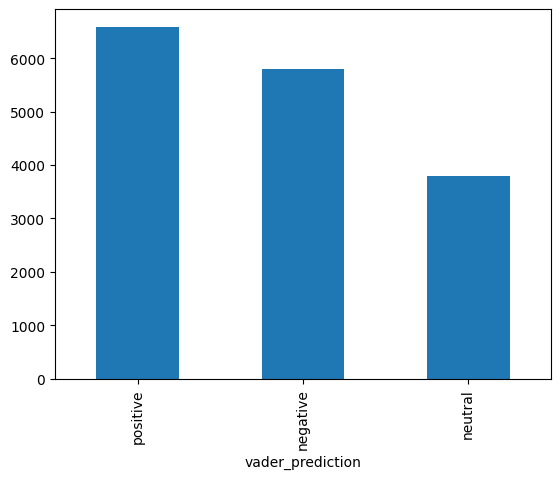

In [21]:
# irish_housing_reddit_df['year'] = irish_housing_reddit_df['created_utc'].dt.year
irish_housing_reddit_df['vader_prediction'].value_counts().plot.bar()

### Persist the dataset to MongoDB
Performing API calls to Reddit could result in exceeding the allowed rate limits. A delay was applied before making each GET request to prevent the throttling. When querying large amount of posts/comments, this process can take long time to complete. So, it can be more efficient to regularly persisting the data to a database, and later querying from it instead of using Reddit API all the time.

In [26]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["ca2"]
# Collection
coll = db['irish_housing_construction']

In [39]:
# Insert the DF rows to MongoDB collection
coll.insert_many(irish_housing_reddit_df.to_dict('records'))

In [40]:
print(f"Estimated documents in MongoDB Collection: {coll.estimated_document_count()}")

Estimated documents in MongoDB Collection: 16194


### European house construction sentiment

In [32]:
europe_housing_reddit_df = pd.DataFrame.from_dict(search_reddit("europe", "house construction"))

No search results after last result ID: t3_bo3d3b
Search results: 34
Total comments retreived: 363


In [33]:
europe_housing_reddit_df['created_utc'] = pd.to_datetime(europe_housing_reddit_df['created_utc'], unit='s')
europe_housing_reddit_df.head()

,created_utc,author,post_id,subreddit,text
0,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...
1,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...
2,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...
3,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted]
4,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou..."


In [34]:
# Store the column of the dataframe named as "text"
X = europe_housing_reddit_df['text']

# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

cleaned_data=[]

# For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
for i in range(len(X)):
    post = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    post = post.lower().split()
    post = [stemmer.stem(word) for word in post if (word not in stop_words) and (word not in punct)]
    post = ' '.join(post)
    cleaned_data.append(post)
    
cleaned_data = pd.Series(cleaned_data)


In [35]:
# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

europe_housing_reddit_df['vader_prediction'] = europe_housing_reddit_df['text'].apply(predict_sentiment)
europe_housing_reddit_df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/bsajjan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,created_utc,author,post_id,subreddit,text,vader_prediction
0,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...,positive
1,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...,neutral
2,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...,positive
3,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted],neutral
4,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou...",positive


In [37]:
coll_europe = db['europe_housing_construction']

# Insert the DF rows to MongoDB collection
coll_europe.insert_many(europe_housing_reddit_df.to_dict('records'))

In [38]:
print(f"Estimated documents in MongoDB Collection: {coll_europe.estimated_document_count()}")

Estimated documents in MongoDB Collection: 363


<Axes: xlabel='vader_prediction'>

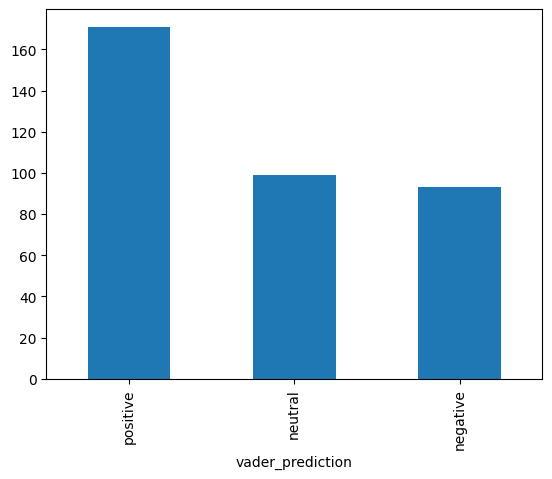

In [41]:
europe_housing_reddit_df['vader_prediction'].value_counts().plot.bar()

In [43]:
new_europe_df = europe_housing_reddit_df
new_europe_df['year'] = new_europe_df['created_utc'].dt.year
new_europe_df[]
# plt.plot(europe_housing_reddit_df[created_utc].dt.year, europe_housing_reddit_df['vader_prediction'])
# plot.show()

In [44]:
new_europe_df.head()

,created_utc,author,post_id,subreddit,text,vader_prediction,year
0,2021-10-07 18:19:16,DevilSauron,q3f6wi,europe,**The Election**\n\nTomorrow and on Saturday (...,positive,2021
1,2021-10-14 13:58:01,Plane_Willingness_25,q3f6wi,europe,So how are things developing? Is Babis still g...,neutral,2021
2,2021-10-09 22:57:31,linknewtab,q3f6wi,europe,Any chance the new government will finally joi...,positive,2021
3,2021-10-09 22:55:50,[deleted],q3f6wi,europe,[deleted],neutral,2021
4,2021-10-09 22:48:07,Freeman3017,q3f6wi,europe,"Victory day for democracy, this is how it shou...",positive,2021


In [45]:
new_europe_df['year'].unique()

array([2021, 2020, 2018, 2023, 2017, 2019, 2014, 2010, 2015, 2022, 2013,
       2016, 2012], dtype=int32)

In [47]:
new_europe_grouped_df = new_europe_df.groupby(['year', 'vader_prediction']).size().reset_index(name="count")

In [48]:
new_europe_grouped_df.head()

,year,vader_prediction,count
0,2010,negative,8
1,2010,neutral,7
2,2010,positive,9
3,2012,positive,1
4,2013,negative,2


<Axes: xlabel='year', ylabel='count'>

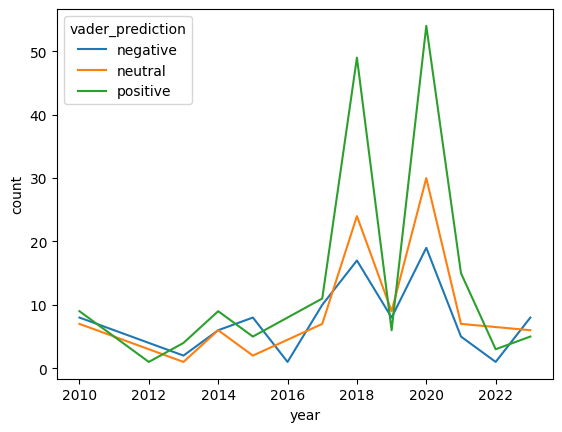

In [49]:
sns.lineplot(data=new_europe_grouped_df, x='year', y='count', hue='vader_prediction')

<Axes: xlabel='year', ylabel='count'>

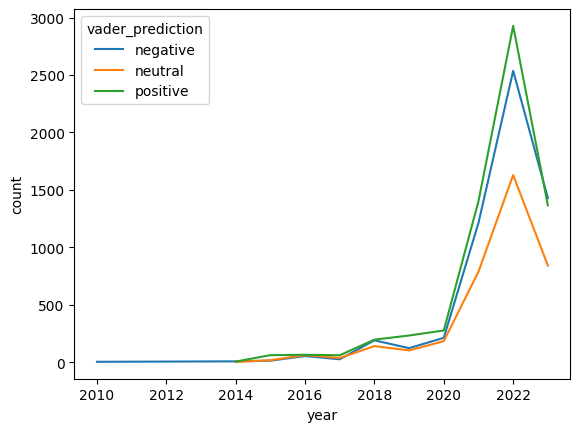

In [50]:
irish_housing_reddit_df['year'] = irish_housing_reddit_df['created_utc'].dt.year
grouped_irish_df = irish_housing_reddit_df.groupby(['year', 'vader_prediction']).size().reset_index(name="count")
sns.lineplot(data=grouped_irish_df, x='year', y='count', hue='vader_prediction')

### Applying Clustering-based Sentiment Analysis

In [55]:
# Initialize the vectorizer and analyzer
vectorizer = TfidfVectorizer(stop_words='english')
analyzer = SentimentIntensityAnalyzer()

In [70]:
# Transform the data into vectors
vectors = vectorizer.fit_transform(irish_housing_reddit_df['text'])

# Perform K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(vectors)

# Apply PCA to reduce the dimensionality of the vectors to 2 dimensions
pca = PCA(n_components=3)
vectors_2d = pca.fit_transform(vectors.toarray())

# Get the cluster labels
cluster_labels = kmeans.labels_

/Users/bsajjan/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


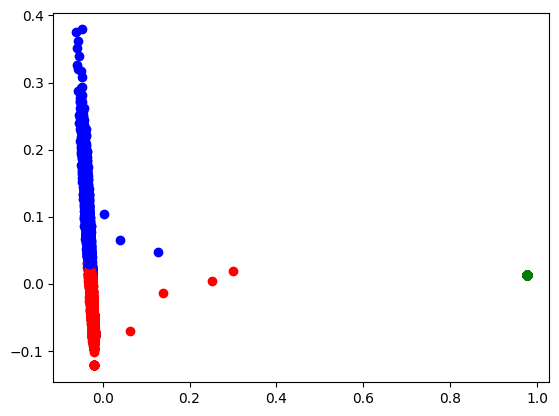

In [71]:
# Create a scatter plot of the data points, colored by cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i in range(len(vectors_2d)):
    plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], color=colors[kmeans.labels_[i]])

plt.show()

In [72]:
# Get the sentiment scores for each document and each cluster
document_scores = []
cluster_scores = []
for i, document in enumerate(irish_housing_reddit_df['text']):
    sentiment_scores = analyzer.polarity_scores(document)
    document_scores.append(sentiment_scores['compound'])
    cluster_scores.append((cluster_labels[i], sentiment_scores['compound']))

In [73]:
# Print the cluster scores
print('Cluster scores:')
for i in range(num_clusters):
    scores = [x[1] for x in cluster_scores if x[0] == i]
    print(f'Cluster {i}: Mean sentiment score = {sum(scores) / len(scores):.2f}')


Cluster scores:
Cluster 0: Mean sentiment score = 0.03
Cluster 1: Mean sentiment score = 0.00
Cluster 2: Mean sentiment score = 0.06


In [74]:
cluster_scores[0]

(2, 0.9964)

In [75]:
document_scores[0]

0.9964